# Information theory, efficient coding and gain control



In [1]:
import numpy as np
import xarray as xr
import seaborn as sns
from tqdm import tqdm

import ndd

In [2]:
from matplotlib import pyplot as plt

In [3]:
from neuron import h
from neuron.units import ms, mV, µm, cm, s

h.load_file("stdrun.hoc")
h.cvode_active(1);

## Define conductance-based integrate-and-fire cell and basic simulation to support FF curve analysis

In [4]:
class COBA:
    """
    This conductance-based integrate and fire neuron is a simplified version of the one used in Mitchell and Silver, Neuron 2003.
    """
    def __init__(self):
        self._setup_morphology()
        self._setup_biophysics()
        
        self._spike_detector = h.NetCon(self.spikeout, None)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)


    def _setup_morphology(self):
        self.soma = h.Section(name="soma", cell=self)
        self.all = self.soma.wholetree()
        self.soma.L = self.soma.diam = 5.6418958 * µm # this way the surface area is about 100µm^2
        self.area = self.soma.L * self.soma.diam * np.pi

    def _setup_biophysics(self):
        self.capacitance = 3.1 # pF
        self.soma.cm = self.capacitance * 1e-6 / (self.area/cm**2) # Membrane capacitance in µF / cm^2
        
        # Create spiking mechanism
        self.spikeout = h.SpikeOut(self.soma(0.5))
        self.spikeout.thresh = -49 * mV # Spike threshold
        self.spikeout.refrac = 2.5 * ms # Refractory period
        self.spikeout.vreset = -75 * mV # Reversal potential to clamp to during the spike
        self.spikeout.grefrac = 100 / (self.area/cm**2) # Conductance used to clamp during refractory period (S/cm2)

        # Inser leak
        self.soma.insert("pas")
        for seg in self.soma:
            seg.pas.g = 385*1e-12 / (self.area/cm**2)  # Passive conductance in S/cm2
            seg.pas.e = -75 * mV  # Leak reversal potential
        
        self.exc = h.ExpSyn(self.soma(0.5))
        self.exc.tau = 10
        self.exc.e = 0
        
        self.inh = h.ExpSyn(self.soma(0.5))
        self.inh.tau = 12
        self.inh.e = -75
        
    def __repr__(self):
        return f"Conductance-based IaF cell"

In [5]:
def rate_simulation(cell=None, exc_rate=10, inh_rate=0, duration=0.4, transient=0.2):
    """
    exc_rate, inh_rate are in Hz
    
    duration and transient are in seconds
    """
    
    cell = cell if cell is not None else COBA()
    
    if exc_rate > 0:
        stim_exc = h.NetStim()
        stim_exc.interval = 1/exc_rate * (s/ms)
        stim_exc.start = 0
        stim_exc.number = exc_rate * duration
        stim_exc.noise = 1
        ncstim_exc = h.NetCon(stim_exc, cell.exc)
        ncstim_exc.delay = 0
        ncstim_exc.weight[0] = 732 * 1e-6

    if inh_rate > 0:
        stim_inh = h.NetStim()
        stim_inh.interval = 1/inh_rate * (s/ms)
        stim_inh.start = 0
        stim_inh.number = inh_rate * duration
        stim_inh.noise = 1
        ncstim_inh = h.NetCon(stim_inh, cell.inh)
        ncstim_inh.delay = 0
        ncstim_inh.weight[0] = 3100 * 1e-6
    
    h.tstop = duration * (s/ms)
    h.v_init = -75
    h.finitialize()
    h.run()
    
    if len(cell.spike_times)==0:
        nspikes = 0
    else:
        spikes = np.array(cell.spike_times)
        nspikes =  (spikes>transient*(s/ms)).sum()
    out_rate = nspikes / (duration-transient)
    
    return out_rate

## Compute FF curve

In [6]:
n_trials = 50
exc_range = np.linspace(0, 1000, 11)
inh_range = np.linspace(0, 100, 6)
ff = np.zeros((exc_range.size, inh_range.size, n_trials))
for trial in tqdm(range(n_trials)):
    for i, exc in enumerate(exc_range):
        for j, inh in enumerate(inh_range):
            ff[i,j,trial] = rate_simulation(exc_rate=exc, inh_rate=inh)

ff = xr.DataArray(data=ff, dims=['Exc rate (Hz)', 'Inh rate (Hz)', 'Trial'], coords=[exc_range, inh_range, range(n_trials)], name='Firing rate (Hz)')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.51it/s]


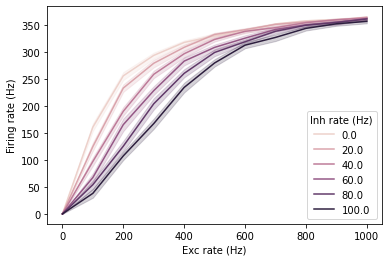

In [7]:
sns.lineplot(data=ff.to_dataframe(), x='Exc rate (Hz)', y='Firing rate (Hz)', hue='Inh rate (Hz)');

Idea: say that you have a neuron like the above. So you can only encode stuff between 0 and 300Hz. So you need to adapt your gain to your input range. We will show below:
1. how to estimate the mutual information between the input and the output of this cell (where the input is defined as its excitatory drive);
2. the effect of undersampling on the information estimate, and how it can be reduced through bias correction;
3. how adapting the gain to the stimulus distribution according to efficient coding theory results in optimal information transmission.

can make an interactive simulation where you can pick the input range and the gain, and you can discover that (a' la van Hateren, given the nature of the constraints in this case), higher input range calls for smaller gain. This can be used as an example to make concrete the van hateren prediction in one regime.

In [8]:
def input_output_simulation(exc_max, inh, n_trials=100):
    in_freqs = np.random.uniform(low=0, high=exc_max, size=n_trials)
    out_freqs = np.array([rate_simulation(exc_rate=exc, inh_rate=inh, transient=0.3, duration=0.5) for exc in in_freqs])
    return in_freqs, out_freqs

def digitize(array, n_bins, mode='uniform'):
    if mode=='uniform':
        digitized = np.digitize(array, bins=np.linspace(array.min(), array.max(), n_bins+1))
    elif mode=='quantiles':
        digitized = np.digitize(array, bins=np.percentile(array, np.linspace(0, 100, n_bins+1)))
    return digitized

def entropy(p):
    p = np.asarray(p)
    p = p[p>0]
    return (-p * np.log2(p)).sum()

def mutual_information_naive(xy):
    xy = np.asarray(xy)
    x = xy[:,0]
    y = xy[:,1]
    
    alphabet_x, counts_x = np.unique(x, return_counts=True)
    alphabet_y, counts_y = np.unique(y, return_counts=True)
    
    # marginal probability dist of Y: p(Y=y)
    py = counts_y/counts_y.sum()
    # marginal entropy H[Y]
    HY = entropy(py)
    
    # conditional probability distribution of Y given X: p(Y=y|X=x) and its entropy H[Y|X=x]
    HY_x = np.zeros(alphabet_x.size)
    
    for i, this_x in enumerate(alphabet_x):
        _, counts = np.unique(y[x==this_x], return_counts=True)
        py_x = counts/counts.sum()
        HY_x[i] = entropy(py_x)
    
    # average H[Y|X=x] over p(x) to obtain the conditional entropy H[Y|X]=ΣH[Y|X=x]p(x)
    HY_X = np.inner(HY_x,  counts_x/counts_x.sum())
    
    # mutual information is marginal entropy minus conditional entropy: MI[X:Y]=H[Y]-H[Y|X]
    IXY = HY - HY_X
    
    return IXY


def estimate_information(exc_max, inh, n_bins=10, bias_correction=True, **kwargs):
    # simulate stimulus-response for a number of trials
    in_freqs, out_freqs = input_output_simulation(exc_max, inh, **kwargs)
    # bin stimulus and response firing rates
    in_binned = digitize(in_freqs, n_bins=n_bins)
    out_binned = digitize(out_freqs, n_bins=n_bins)
    # compute mutual information
    io_table = np.vstack((in_binned, out_binned)).T
    if bias_correction:
        # using NSB method (note unit conversion, as the ndd module returns a result in nats, not bits)
        information = ndd.mutual_information(io_table) * np.log2(np.e)
    else:
        information = mutual_information_naive(io_table)
    return information

## Demonstrate undersampling bias

In [9]:
# TODO: add repetitions and error bars in the plots, to give an idea of the estimate variance (besides the bias)

n_bins_range = np.arange(2, 13, 2, dtype='int')
n_trials_range = np.round(np.logspace(1, 2.5, 6)).astype('int')

mi_corrected = np.zeros((n_bins_range.size, n_trials_range.size))
mi_naive = np.zeros((n_bins_range.size, n_trials_range.size))
for i, n_bins in enumerate(tqdm(n_bins_range)):
    for j, n_trials in enumerate(n_trials_range):
        in_freqs, out_freqs = input_output_simulation(exc_max=200, inh=10, n_trials=n_trials)
        in_binned = digitize(in_freqs, n_bins=n_bins)
        out_binned = digitize(out_freqs, n_bins=n_bins)
        io_table = np.vstack((in_binned, out_binned)).T
        mi_corrected[i,j] = ndd.mutual_information(io_table) * np.log2(np.e)
        mi_naive[i,j] = mutual_information_naive(io_table)
        
bias_comparison = xr.DataArray(
    data=np.stack((mi_corrected, mi_naive)),
    dims=['Estimator', 'N. of bins', 'N. of trials'],
    coords=[['Bias-corrected (NSB)', 'Naive'], n_bins_range**2, n_trials_range],
    name='Mutual Information (bit)'
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:21<00:00,  3.52s/it]


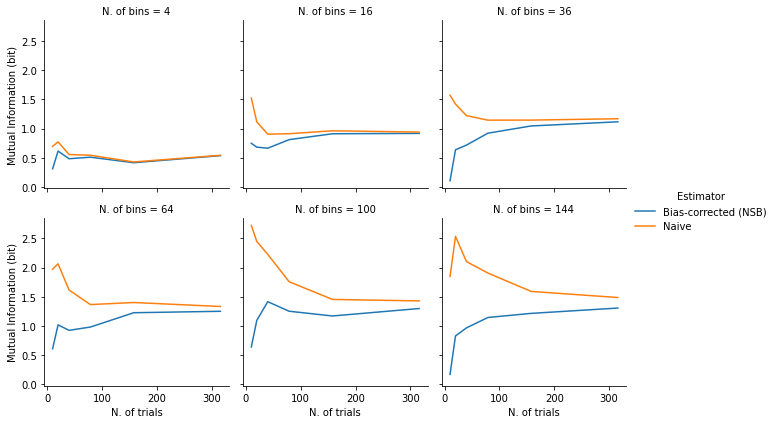

In [10]:
g = sns.FacetGrid(data=bias_comparison.to_dataframe().reset_index(), col='N. of bins', col_wrap=3, hue='Estimator')
g.map(sns.lineplot, 'N. of trials', 'Mutual Information (bit)')
g.add_legend();

We can see that, for sufficiently large number of trials, the MI estimates converge, regardless of the estimator (with or without bias correction). However, when data is scarce (low N. of trials) the naive approach systematically overestimates the information. The bias-corrected estimator also behaves poorly at extremely low N. of trials, but in general it converges to sensible values faster than the naive approach. Note also that the undersampling bias gets worse as the dimensionality of the input/output relationship considered (number of bins, in this case) increases.

## Demonstrate optimal gain control

In [11]:
n_trials = 1000
n_bins = 4
exc_max_range = np.linspace(0, 1000, 6)
inh_range = np.linspace(0, 100, 6)
mi = np.zeros((exc_max_range.size, inh_range.size))
for i, exc_max in enumerate(tqdm(exc_max_range)):
    for j, inh in enumerate(inh_range):
        mi[i,j] = estimate_information(exc_max, inh, n_bins=n_bins, n_trials=n_trials)

mi = xr.DataArray(data=mi, dims=['Exc input range (Hz)', 'Inh rate (Hz)'], coords=[exc_max_range, inh_range], name='Mutual Information (bit)')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [04:59<00:00, 49.92s/it]


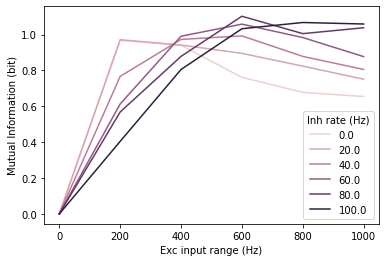

In [12]:
sns.lineplot(data=mi.to_dataframe(), x='Exc input range (Hz)', y='Mutual Information (bit)', hue='Inh rate (Hz)');

By looking at the curves above, we can see that as the dynamic range of the stimulus increases (on the x axis) the optimal configuration that transmits the most information has more and more inhibition. This is because, as shown by the FF curve we computed at the beginning of the notebook, higher inhibition results in lower "gain" for the rate-transfer function of the neuron, allowing the neuron to transmit information over a broader range of inputs. In other words, when the gain is high (low inhibition) the neuron is very sensitive over a narrow range of stimuli, but saturates for relatively low input frequencies; on the other hand, when gain is low (high inhibition) the neuron is never as sensitive as a high-gain neuron, but maintains its sensitivity over a broader input range.